# Homework 2 

- Implement Naive Bayes model (remember about smoothing). 
- Find a reasonably interesting but not to complicated dataset for which you will be able to use this model to perform binary classification. Do the latter.
- Produce the confussion matrix, calculate accuracy, precission, recall
- Check how your model does against its version from sklearn and logistic regression from sklearn. 

In [1]:
import pandas as pd
import numpy as np
import math
import random

In [2]:
%matplotlib inline
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import precision_score, recall_score

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
import seaborn as sns

## Bayes Implementation

In [4]:
def splitDataSet(dataset, splitratio):

    length = range(len(dataset))
    testrange = random.sample(length, int(splitratio * len(dataset)))
    testrange.sort()
    trainrange = list(set(length) ^ set(testrange))

    testchunk = dataset.ix[testrange]
    trainchunk = dataset.ix[trainrange]

    return trainchunk, testchunk

In [5]:
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if(vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated

In [6]:
def summarize(dataset):
    summaries = [(np.mean(n), np.std(n)) for n in zip(*dataset)]
    del summaries[-1]
    return summaries

In [7]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classvalue, instances in separated.items():
        summaries[classvalue] = summarize(instances)
    return summaries

In [8]:
def calculateProbability(x, mean, stdev):
    exp = math.exp(-((x-mean)*(x-mean)/(2*(stdev*stdev))))
    return(1/(math.sqrt(2*math.pi)*stdev)) * exp

In [9]:
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

In [10]:
def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    best, prob = None, -1
    for classValue, probability in probabilities.items():
        if best is None or probability > prob:
            prob = probability
            best = classValue
    return best

In [11]:
def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions

In [12]:
def getAccuracy(testSet, predictions):
    correct = 0;
    size = float(len(testSet))
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct / size) * 100

In [13]:
def confusionMatrix(true, pred):
    result = np.zeros((2, 2))

    for i in range(len(true)):
        trueval = true[i][1]
        if(trueval != pred[i] and pred[i] == 0):
            result[0][1] += 1
        if(trueval == pred[i] and pred[i] == 0):
            result[0][0] += 1
        if(trueval != pred[i] and pred[i] == 1):
            result[1][0] += 1
        if(trueval == pred[i] and pred[i] == 1):
            result[1][1] += 1

    return result

## Main idea of test
I've downloaded a dataset from 
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
containing data about adults in USA. Main idea was to check if there is a correlation between being in relationship and income per year. First thing I did was to get a dataset. Then I've dropped collumns that i don't need.

In [14]:
data = pd.read_csv("adult.test",sep=',', encoding='utf-8')
data = data.drop(["workclass", "age", "education", "fnlwgt", "education-num", "occupation", "relationship", "race", "capital-gain", "capital-loss", "hours-per-week", "nationality", "sex"], axis=1)
data.head()

,martial-status,cap-per-year
0,Never-married,<=50K.
1,Married-civ-spouse,<=50K.
2,Married-civ-spouse,>50K.
3,Married-civ-spouse,>50K.
4,Never-married,<=50K.


In [15]:
data = data.rename(columns={"martial-status":"label", "cap-per-year":"cap"})
data.label.value_counts()

 Married-civ-spouse       7403
 Never-married            5434
 Divorced                 2190
 Widowed                   525
 Separated                 505
 Married-spouse-absent     210
 Married-AF-spouse          14
Name: label, dtype: int64

In [16]:
data['label_num_val'] = data.label.map({' Never-married':0, ' Married-civ-spouse':1, ' Divorced':0, ' Widowed':0,' Separated':1, ' Married-spouse-absent':0,' Married-AF-spouse':0})
data['cap_val'] = data.cap.map({' <=50K.':1,' >50K.':0 })
data.label = data.label_num_val
data.cap = data.cap_val
data = data.drop(["label_num_val","cap_val"], axis=1)
data.head()

,label,cap
0,0,1
1,1,1
2,1,0
3,1,0
4,0,1


In [17]:
#First we evaluate the data using our implementation of the Bayes Model
splitRatio = 0.2
trainingSet, testSet = splitDataSet(data, splitRatio)
print("Splitting {0} rows into {1} training and {2} testing ranges".format(len(data), len(trainingSet), len(testSet)))

#Conversion into lists
trainingSetlist = trainingSet.values.tolist()
testSetlist = testSet.values.tolist()

Splitting 16281 rows into 13025 training and 3256 testing ranges


/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [18]:
summaries = summarizeByClass(trainingSetlist)

In [19]:
predictions = getPredictions(summaries, testSetlist)
accuracy = getAccuracy(testSetlist, predictions)
print("Accuracy: {0}%".format(accuracy))

Accuracy: 67.93611793611794%


[[ 637.  951.]
 [  93. 1575.]]


Text(0.5,16,'Predicted label')

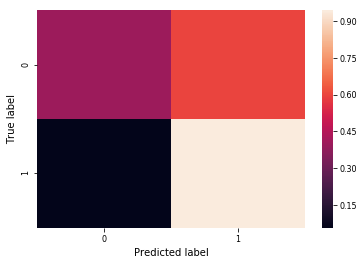

In [20]:
#Producing a confusion matrix
confmat = confusionMatrix(testSetlist, predictions)
print(confmat)
confmat_normalized = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
sns.heatmap(confmat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
#Calculating precision and recall scores
precision = confmat.item(1, 1)/(confmat.item(1, 1) + confmat.item(0, 1))
recall = confmat.item(1, 1)/(confmat.item(1, 1) + confmat.item(1, 0))
print("Precision: {0}\nRecall: {1}".format(precision, recall))

Precision: 0.6235154394299287
Recall: 0.9442446043165468


## Comparasion with sklearn

In [22]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data["cap"],data["label"], test_size = 0.2, random_state = 10)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13024,)
(3257,)
(13024,)
(3257,)


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

At this point I've encountered problems, on one of terminalas my implementation would work but on the other one I've had problems with type conversions.

In [ ]:
vect.fit(X_train)

In [ ]:
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

Here we apply logistic regression

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)
prediction = model.predict(X_test)
acc = accuracy_score(y_test,prediction)
print("Accuracy: {0}%".format(acc*100))

In [ ]:
conf_mat = confusion_matrix(y_test, prediction)
print("Sklearn Confusion Matrix:\n{0}\nMy Confusion Matrix:\n{1}".format(conf_mat, confmat))

In [ ]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y_test, prediction, target_names = ["Martial-Status", "Year Income"]))

## Results
Naive bayes is a good and fast model to create for classification. Even though results may differ a little bit, it's rather small difference.